In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math as mt
import random as rand
from mpl_toolkits.mplot3d import axes3d

from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

ro.numpy2ri.activate()
pandas2ri.activate()

In [2]:
parser = lambda date: pd.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv("sorted.csv", nrows=200000, parse_dates=[1], date_parser=parser, index_col=0)


In [3]:
def findDateIndex(date):
    # start date of first full day of observations in the data
    start_date = dt.date(2006, 12, 17)
    #how many days have passed between start date and input date
    days = (date - start_date).days

    # return the index: 60 obs/minute; 1440 obs/day
    # we return the csv row where our input date occurs
    return days*1440

In [4]:
def getRefWindow(num, wintype, date):
    idx = findDateIndex(date)

    #create empty data frames
    rf = pd.DataFrame([])
    tf = pd.DataFrame([])

    #now jump back (wintype = 7 for day_period, day, or week), and copy slices into our new DataFrame
    idx = idx - (num*1440*wintype)

    # add reference windows to dataframe
    for i in range(0,num):
      # I think the 1:2 is the global active power column
      rf = rf.append(data.iloc[idx+day_start:idx+day_end, 1:2])

      #output to csv for testing.
      temp = data.iloc[idx+day_start:idx+day_end, 1:2]
      temp.to_csv('ref' + str(i) + '.csv', header=False, index=False)

      # advance through the days and append
      idx = idx + (1440*wintype)

    # get test window
    tf = tf.append(data.iloc[idx+day_start:idx+day_end, 1:2])
    # output to csv
    tf.to_csv('testwin.csv', header=False, index=False)

    return rf.as_matrix(), tf

In [5]:
rstring="""
        function(){

            library("mhsmm")

            # grab the training window data
            data1 = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/ref0.csv",header=FALSE))
            data1 = as.numeric(data1)
            data1List = list(x=data1, N=length(data1))

            data2 = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/ref1.csv",header=FALSE))
            data2 = as.numeric(data2)
            data2List = list(x=data2, N=length(data2))

            data3 = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/ref2.csv",header=FALSE))
            data3 = as.numeric(data3)
            data3List = list(x=data3, N=length(data3))


            train = list(x=c(data1,data2,data3), N=c(length(data1),length(data2),length(data2)))
            class(train) <- "hsmm.data"

            # grab the testing window data
            
            dataT = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/testwin.csv",header=FALSE))
            dataT = as.numeric(dataT)
            test = list(x=dataT, N=length(dataT))
            class(test) <- "hsmm.data"


            # initialize values for learning the HSMM

            J <- 4
            M = 150

            d <- cbind(dunif(1:M,0,150),
                       dunif(1:M,0,150),
                       dunif(1:M,0,150),
                       dunif(1:M,0,150))

            start.np <- hsmmspec(init=rep(1/J,J),
                                 transition=matrix(c(.00,.5,.5,.5,
                                                     .5,.00,.5,.5,
                                                     .5,.50,.00,.50,
                                                     .5,.50,.50,.00),nrow=J),
                                 parms.emission=list(mu=c(0.5, 1.5, 2.5, 3.5),
                                                     sigma=c(0.75, 0.5, 0.5, 0.5)),
                                 sojourn=list(d=d,type='nonparametric'),
                                 dens.emission=dnorm.hsmm)

            #fit the model
            h.act <- hsmmfit(train,start.np,mstep=mstep.norm,M=M,graphical=FALSE)
            
            # predict on test window
            p_test <- predict(h.act,test)
            
            #predict each reference window
            p_ref0 <- predict(h.act,data1)
            p_ref1 <- predict(h.act,data2)
            p_ref2 <- predict(h.act,data3)

            # output for analysis
            
            em <- summary(h.act)
            
            output <- list(t1 = p_test$s, r0 = p_ref0$s, r1 = p_ref1$s, r2 = p_ref2$s, mu = em$mu, sigma = em$sigma) 
            
            output
           
        }
    """

In [374]:
###################
# Parameters
###################

test_date = dt.date(2007, 2, 28)

num_ref = 3
win_type = 7
day_start = 420
#1900
day_end = 1140

length = day_end - day_start

rw,tw = getRefWindow(num_ref, win_type, test_date)

In [292]:
rfunc=ro.r(rstring)
    # call the function in R and return the log likelyhood
predict=rfunc()

[1]
 2.795626e-09
 5.641892e-01


[1]
 4.327103e-29
 9.349500e-01


[1]
 2.663977e-47
 1.193971e+00


[1]
 1.064199e-66
 1.416034e+00


[1]
 3.237903e-74
 1.492740e+00


[1]
 3.336740e-78
 1.531735e+00


[1]
 6.855265e-85
 1.594616e+00


[1]
 1.251616e-91
 1.655316e+00


[1]
 1.156562e-97
 1.790723e+00


[1]
 3.338666e-107
  1.932840e+00


[1]
 1.929698e-112
  2.029920e+00


[1]
 4.304485e-113
  2.091171e+00


[1]
 1.649407e-113
  2.143479e+00


[1]
 2.824054e-114
  2.187933e+00


[1]
 3.34319e-114
  2.21976e+00


[1]
 6.798687e-114
  2.241843e+00


[1]
 1.278785e-113
  2.259764e+00


[1]
 3.791675e-114
  2.275305e+00


[1]
 1.590062e-115
  2.288621e+00


[1]
 8.610353e-117
  2.300971e+00


[1]
 4.826024e-118
  2.313125e+00


[1]
 2.308167e-119
  2.325897e+00


[1]
 5.756356e-121
  2.341378e+00


[1]
 1.066315e-122
  2.358154e+00


[1]
 3.538547e-124
  2.372487e+00


[1]
 3.887350e-125
  2.381738e+00


[1]
 1.168170e-125
  2.386737e+00


[1]
 5.891507e-126
  2.389560e+00


[1]
 3.84056

In [378]:
# extract info from R ouput

seq0 = np.asarray(predict[0])
seq1 = np.asarray(predict[1])
seq2 = np.asarray(predict[2])
seq3 = np.asarray(predict[3])

obs_mu = np.asarray(predict[4])
obs_sigma = np.asarray(predict[5])

In [379]:
def checkPoint(i, threshold):
    
    dist = abs(tw[i] - obs_mu[int(seq0[i])-1])
    
    if ( dist > obs_sigma[int(seq0[i])-1]*threshold):
          return dist, tw[i]
    else:
          return 0, None
    

In [380]:
# determine mean and sigma
# observations, mu and sigma, state sequence

def getPASD(threshold1, threshold2, threshold3, threshold4):
    
    point_anom = np.zeros(ref0.shape[0])
    new_plot = np.zeros(ref0.shape[0])
    
    for i in range(tw.shape[0]):
        
        if (int(seq0[i]) == 1):
           dist, newp = checkPoint(i, threshold1)
        
        elif (int(seq0[i]) == 2):
           dist, newp = checkPoint(i, threshold2)
        
        elif (int(seq0[i]) == 3):
           dist, newp = checkPoint(i, threshold3)
        
        elif (int(seq0[i]) == 4):
           dist, newp = checkPoint(i, threshold4)
           
             
        point_anom[i] = dist
        new_plot[i] = newp 
    
    
    return point_anom, new_plot
    

In [381]:
def getPAKNN(testw, ts, K, threshold):
    
    # magnitude of PA's
    point_anom = np.zeros(testw.shape[0])
    # a new plot containing PAs, and nothing otherwise, so we can superimpose over the original plot
    new_plot = np.zeros(ref0.shape[0])
    
    w = int(mt.floor(K / 2))
    
    for i in range(w, testw.shape[0]):
        
        dist = np.mean(abs(ts[i] - ts[i-w:i+w+1]))
        
        if (dist > threshold ):
            point_anom[i] = dist
            new_plot[i] = testw[i]
        else:
            point_anom[i] = 0
            new_plot[i] = None
            
    return point_anom, new_plot
        

In [382]:
# tw = observation array, ts = sequence array
def cleanSeq(testw, ts, K, tstate, tobs):
    
    new_ts = np.copy(ts)
    #new_ts = np.zeros(ts.shape[0])
    state_changes = np.zeros(ts.shape[0])
    
    w = int(mt.floor(K / 2))
    
    for i in range(w, ts.shape[0]):
        
        # is it anomalous?
        state_dist = np.mean(abs(float(ts[i]) - ts[i-w:i+w+1]))
    
        
        if (state_dist > tstate):
            # if it is, is it a false positive?
            obs_dist = abs(np.mean(float(testw[i]) - testw[i-w:i+w+1]))
        
            if (obs_dist < tobs):
                #get new state
                
                new_state = int( (np.sum(ts[i-w:i]) + np.sum(ts[i+1:i+1+w])) / (w*2))
                new_ts[i] = new_state
                state_changes[i] = new_state  
        
            
    return state_changes, new_ts

In [384]:
tw = pd.read_csv("testwin.csv", header=None)
ref0 = pd.read_csv("ref0.csv", header=None)
ref1 = pd.read_csv("ref1.csv", header=None)
ref2 = pd.read_csv("ref2.csv", header=None)

tw = tw.as_matrix().reshape((tw.shape[0],))
ref0 = ref0.as_matrix().reshape((ref0.shape[0],))
ref1 = ref1.as_matrix().reshape((ref1.shape[0],))
ref2 = ref2.as_matrix().reshape((ref2.shape[0],))


In [385]:
#K = 4 max dist is 2.39ish

#
# test PA detection filters
#

point_anom1, new_tw1 = getPAKNN(tw, seq0, 4, 2)
state_changes, new_ts = cleanSeq(tw, seq0, 4, 2, 1.2)
point_anom2, new_tw2 = getPAKNN(tw, new_ts, 4, 2)


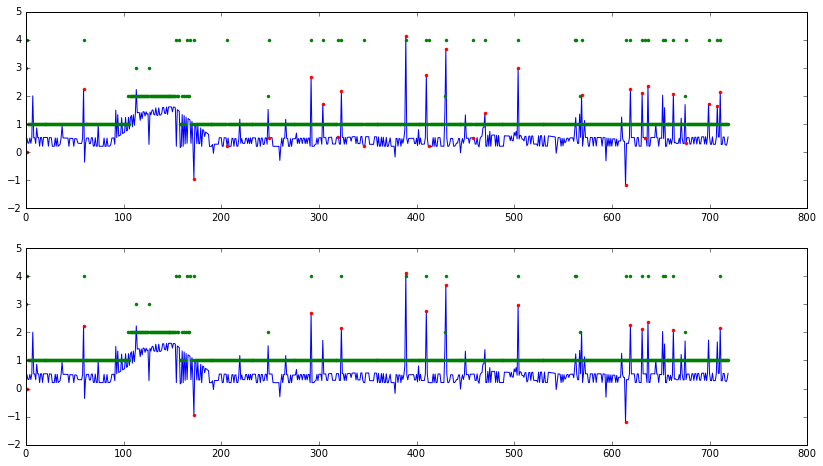

In [373]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(seq0, 'g.')
plt.plot(new_tw1, 'r.')
plt.subplot(312)
#plt.plot(tw)
plt.plot(tw)
plt.plot(new_tw2, 'r.')
plt.plot(new_ts, 'g.')
plt.show()

In [386]:
#
# Test collective anomaly detection filters
#


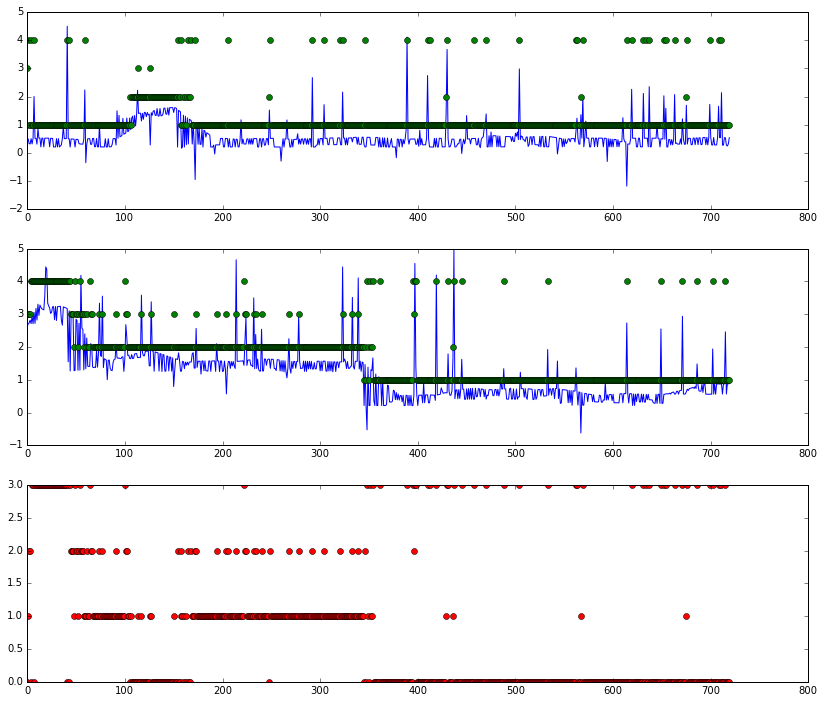

In [60]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(seq0, 'go')
plt.subplot(312)
plt.plot(ref0)
plt.plot(seq1, 'go')
plt.subplot(313)
plt.plot(test1, 'ro')
plt.show()

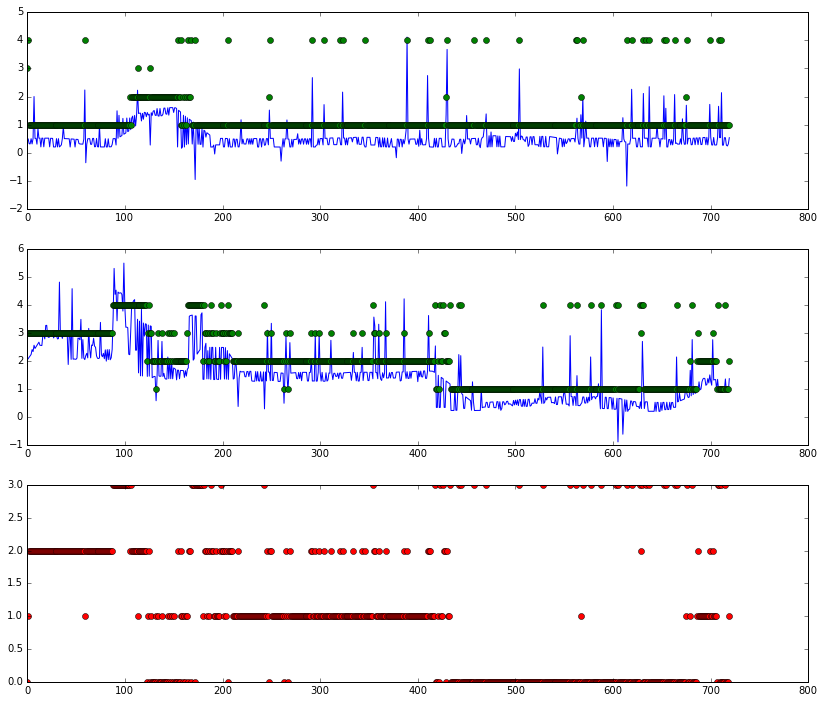

In [23]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(seq0, 'go')
plt.subplot(312)
plt.plot(ref1)
plt.plot(seq2, 'go')
plt.subplot(313)
plt.plot(test2, 'ro')
plt.show()

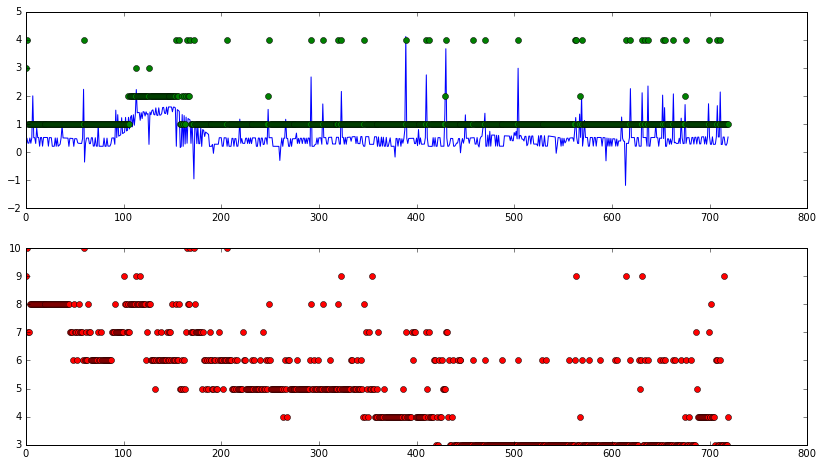

In [26]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(seq0, 'go')
plt.subplot(312)
plt.plot(seqsum, 'ro')
plt.show()

In [461]:
#
# Maximum avg subarray parameters
#

# sum of the sequence arrays
test1 = abs(seq0 - seq1) # test vs ref0
test2 = abs(seq0 - seq2) # test vs ref1
test3 = abs(seq0 - seq3) # test vs ref2

seqsum = test1 + test2 + test3

#max/min length -- these need to have (max-min) >= 2 for a single window
max_length = 20
min_length = 5

# density threshold
dt = 6
# initial window size
k = max_length
#max number of scores
score_max = 5
#number of window sizes
w = int(mt.floor(mt.log((max_length-min_length), 2)))

In [462]:
int(mt.floor(mt.log((max_length-min_length), 2)))

3

In [463]:
X = np.zeros(w*length)
Y = np.zeros(w*length)
Z = np.zeros(w*length)

for i in range(w):
  X[i*length:i*length+length] = i+1
  Y[i*length:i*length+length] = np.arange(length)

dx = np.ones(w*length)
dy = np.ones(w*length)
dz = np.zeros(w*length)

In [464]:
#
# max avg subarray algorithm
#


for i in range(0,w):

    # reset number of scores for this window size
    score_count = 0
    #slide the window over everything, take scores over the threshold
    for j in range(0,seqsum.shape[0] - (k-1)):

      s = float(np.sum(seqsum[j:j+k]))

      d = float(s / k)
        
      #print(arr[j:j+k], " ", d, d>dt, " ", ((j+k+j)/2))
      if ((d > dt)):
          Z[i*length+int((j+k+j)/2)] += d
          #print(Z[int((j+k+j)/2),i], " ", d, " ", j, " ", j+k, " ", int((j+k+j)/2))
          score_count += 1

    # cut the window size in half
    k = int(mt.floor(k / 2))



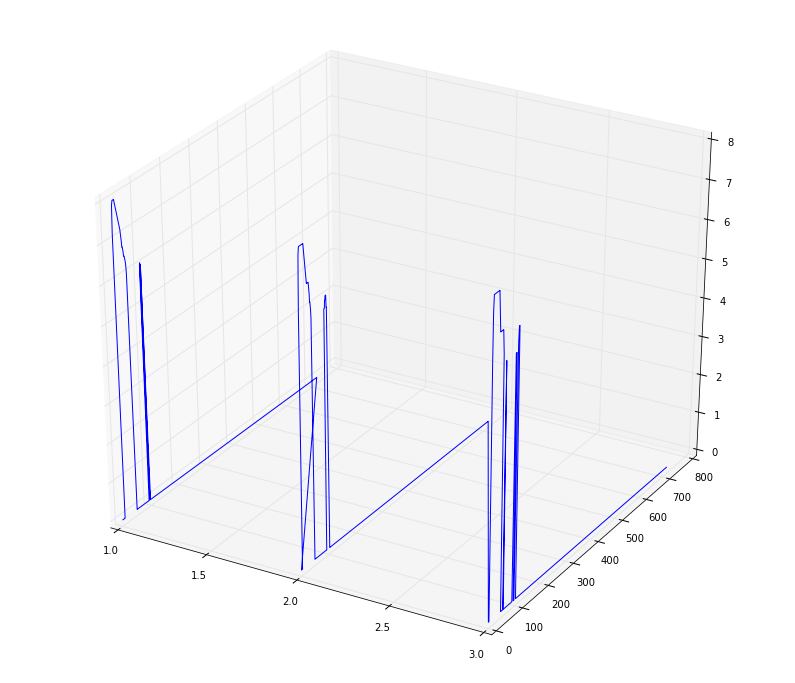

In [465]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(X, Y, Z)
plt.show() 